In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare
from datetime import timedelta

# Simulate daily close price data for SPX and Nikkei over 5 years (approx. 1260 trading days)
np.random.seed(42)
dates = pd.bdate_range(start="2018-01-01", end="2023-01-01", freq="C")
n_days = len(dates)

# Simulated price series
def generate_price_series(n_days, drift=0.0002, vol=0.01):
    returns = np.random.normal(loc=drift, scale=vol, size=n_days)
    price = 100 * np.exp(np.cumsum(returns))
    return price

spx_prices = generate_price_series(n_days)
nikkei_prices = generate_price_series(n_days, drift=0.0001, vol=0.012)

# Construct the DataFrame
df_equity = pd.DataFrame({
    "Date": dates,
    "SPX": spx_prices,
    "Nikkei": nikkei_prices
}).set_index("Date")

# Input data structure
data = {
    "Equity": df_equity,
    "FX": pd.DataFrame(),
    "Commodity": pd.DataFrame(),
    "IRS": pd.DataFrame()
}

# Function to calculate log returns
def compute_log_returns(df):
    return np.log(df / df.shift(1))

# Parameters
vol_window = 60
k_months = [1, 3, 6, 9, 12]
horizon_days = list(range(1, 61))
trading_days_per_month = 21

# Precompute returns and volatility
returns = compute_log_returns(df_equity)
volatility = returns.rolling(window=vol_window).std()

# Prepare results containers
panel_a_results = []
panel_c_results = {asset: [] for asset in df_equity.columns}

# Loop through each k (lookback window in months)
for k in k_months:
    lookback_days = k * trading_days_per_month

    signals = returns.rolling(window=lookback_days).sum() / volatility
    signals = signals.shift(1)  # lag the signal to prevent lookahead bias

    # Loop through each forward return horizon h
    for h in horizon_days:
        forward_returns = np.log(df_equity.shift(-h) / df_equity)

        # Flatten into long panel format
        panel_data = []
        for asset in df_equity.columns:
            df_panel = pd.DataFrame({
                'Return': forward_returns[asset],
                'Signal': signals[asset],
                'Date': df_equity.index,
                'Asset': asset
            }).dropna()
            panel_data.append(df_panel)

        df_all = pd.concat(panel_data)

        # Add month for clustering
        df_all['Month'] = df_all['Date'].dt.to_period('M')

        # Set MultiIndex for PanelOLS
        df_all = df_all.set_index(['Asset', 'Date'])

        # Run pooled panel regression with clustering by month
        mod = PanelOLS.from_formula('Return ~ 1 + Signal', data=df_all)
        res = mod.fit(cov_type='clustered', cluster_entity=False, cluster_time=True)

        # Store results
        panel_a_results.append({
            'k': k,
            'h': h,
            'tstat': res.tstats['Signal']
        })

        for asset in df_equity.columns:
            tstat = res.tstats_by_group[asset]['Signal']
            panel_c_results[asset].append({'k': k, 'h': h, 'tstat': tstat})

# Convert results to DataFrames
df_panel_a = pd.DataFrame(panel_a_results)
df_panel_c = {k: pd.DataFrame(v) for k, v in panel_c_results.items()}

# Plot Panel A: t-statistics vs. horizon (h), averaged across assets
fig, ax = plt.subplots(figsize=(12, 6))
for k in k_months:
    df_k = df_panel_a[df_panel_a['k'] == k]
    ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Panel A: t-statistics vs. Forward Return Horizon (All Assets)')
ax.set_xlabel('Forward Return Horizon (days)')
ax.set_ylabel('t-stat of Signal')
ax.legend()
plt.tight_layout()
plt.show()

# Plot Panel C: t-statistics vs. horizon for each asset separately
fig, axs = plt.subplots(1, len(df_panel_c), figsize=(14, 5), sharey=True)
for i, (asset, df_asset) in enumerate(df_panel_c.items()):
    ax = axs[i]
    for k in k_months:
        df_k = df_asset[df_asset['k'] == k]
        ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'Panel C: {asset}')
    ax.set_xlabel('horizon (days)')
    if i == 0:
        ax.set_ylabel('t-stat')
    ax.legend()
plt.tight_layout()
plt.show()


AttributeError: 'PanelEffectsResults' object has no attribute 'tstats_by_group'

In [4]:
pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 46.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


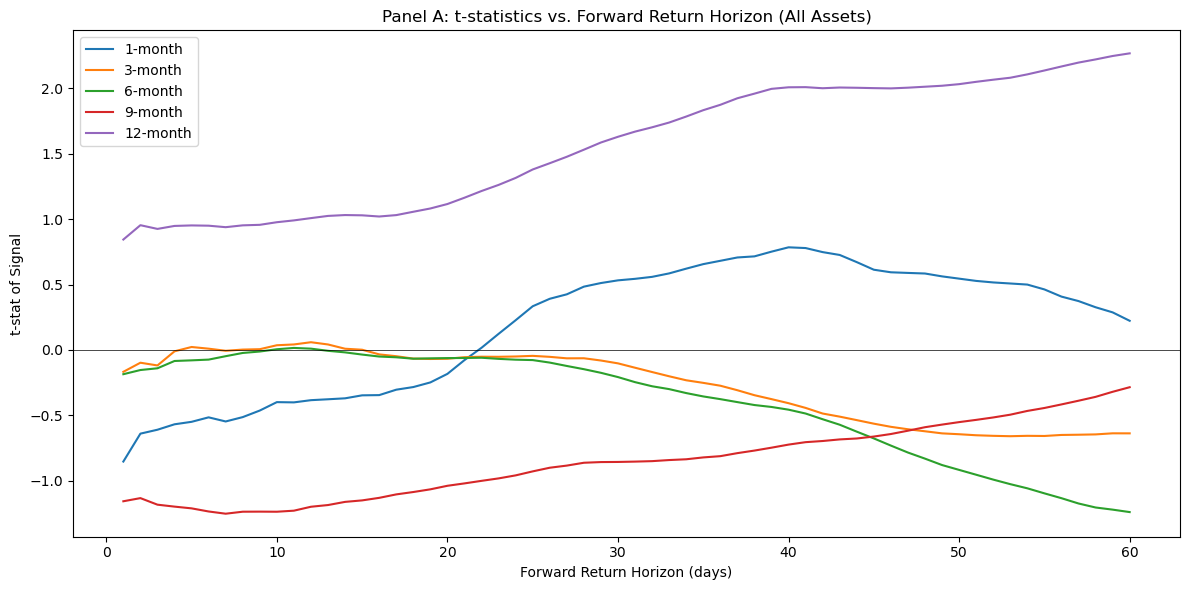

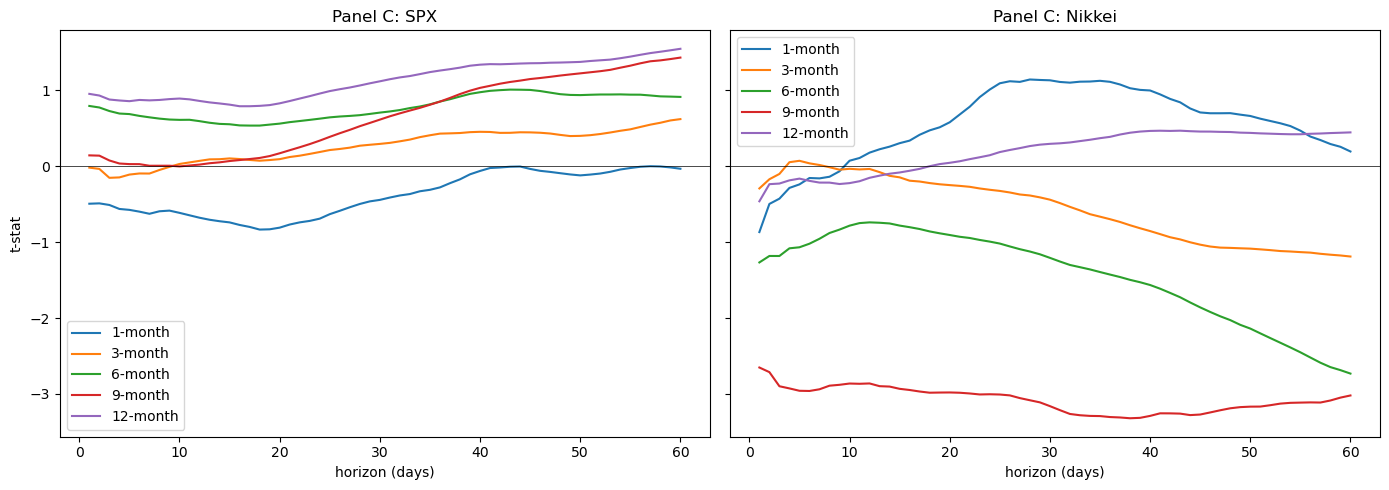

In [11]:
# Updated implementation using statsmodels with manual clustering by month

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta

# Simulate daily close price data for SPX and Nikkei over 5 years (approx. 1260 trading days)
np.random.seed(42)
dates = pd.bdate_range(start="2018-01-01", end="2023-01-01", freq="C")
n_days = len(dates)

# Simulated price series
def generate_price_series(n_days, drift=0.0002, vol=0.01):
    returns = np.random.normal(loc=drift, scale=vol, size=n_days)
    price = 100 * np.exp(np.cumsum(returns))
    return price

spx_prices = generate_price_series(n_days)
nikkei_prices = generate_price_series(n_days, drift=0.0001, vol=0.012)

# Construct the DataFrame
df_equity = pd.DataFrame({
    "Date": dates,
    "SPX": spx_prices,
    "Nikkei": nikkei_prices
}).set_index("Date")

# Input data structure
data = {
    "Equity": df_equity,
    "FX": pd.DataFrame(),
    "Commodity": pd.DataFrame(),
    "IRS": pd.DataFrame()
}

# Function to calculate log returns
def compute_log_returns(df):
    return np.log(df / df.shift(1))

# Parameters
vol_window = 60
k_months = [1, 3, 6, 9, 12]
horizon_days = list(range(1, 61))
trading_days_per_month = 21

# Precompute returns and volatility
returns = compute_log_returns(df_equity)
volatility = returns.rolling(window=vol_window).std()

# Prepare results containers
panel_a_results = []
panel_c_results = {asset: [] for asset in df_equity.columns}

# Loop through each k (lookback window in months)
for k in k_months:
    lookback_days = k * trading_days_per_month

    signals = returns.rolling(window=lookback_days).sum() / volatility
    signals = signals.shift(1)  # lag the signal to prevent lookahead bias

    # Loop through each forward return horizon h
    for h in horizon_days:
        forward_returns = np.log(df_equity.shift(-h) / df_equity)

        # Flatten into long panel format
        panel_data = []
        for asset in df_equity.columns:
            df_panel = pd.DataFrame({
                'Return': forward_returns[asset],
                'Signal': signals[asset],
                'Date': df_equity.index,
                'Asset': asset
            }).dropna()
            panel_data.append(df_panel)

        df_all = pd.concat(panel_data)

        # Add month for clustering
        df_all['Month'] = df_all['Date'].dt.to_period('M')

        # Run pooled regression with clustering
        df_all['Intercept'] = 1
        clusters = df_all['Month'].astype(str)
        model = sm.OLS(df_all['Return'], df_all[['Intercept', 'Signal']])
        results = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})

        # Store results
        panel_a_results.append({
            'k': k,
            'h': h,
            'tstat': results.tvalues['Signal']
        })

        for asset in df_equity.columns:
            df_asset = df_all[df_all['Asset'] == asset]
            clusters_asset = df_asset['Month'].astype(str)
            model_asset = sm.OLS(df_asset['Return'], df_asset[['Intercept', 'Signal']])
            results_asset = model_asset.fit(cov_type='cluster', cov_kwds={'groups': clusters_asset})
            tstat = results_asset.tvalues['Signal']
            panel_c_results[asset].append({'k': k, 'h': h, 'tstat': tstat})

# Convert results to DataFrames
df_panel_a = pd.DataFrame(panel_a_results)
df_panel_c = {k: pd.DataFrame(v) for k, v in panel_c_results.items()}

# Plot Panel A: t-statistics vs. horizon (h), averaged across assets
fig, ax = plt.subplots(figsize=(12, 6))
for k in k_months:
    df_k = df_panel_a[df_panel_a['k'] == k]
    ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Panel A: t-statistics vs. Forward Return Horizon (All Assets)')
ax.set_xlabel('Forward Return Horizon (days)')
ax.set_ylabel('t-stat of Signal')
ax.legend()
plt.tight_layout()
plt.show()

# Plot Panel C: t-statistics vs. horizon for each asset separately
fig, axs = plt.subplots(1, len(df_panel_c), figsize=(14, 5), sharey=True)
for i, (asset, df_asset) in enumerate(df_panel_c.items()):
    ax = axs[i]
    for k in k_months:
        df_k = df_asset[df_asset['k'] == k]
        ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'Panel C: {asset}')
    ax.set_xlabel('horizon (days)')
    if i == 0:
        ax.set_ylabel('t-stat')
    ax.legend()
plt.tight_layout()
plt.show()


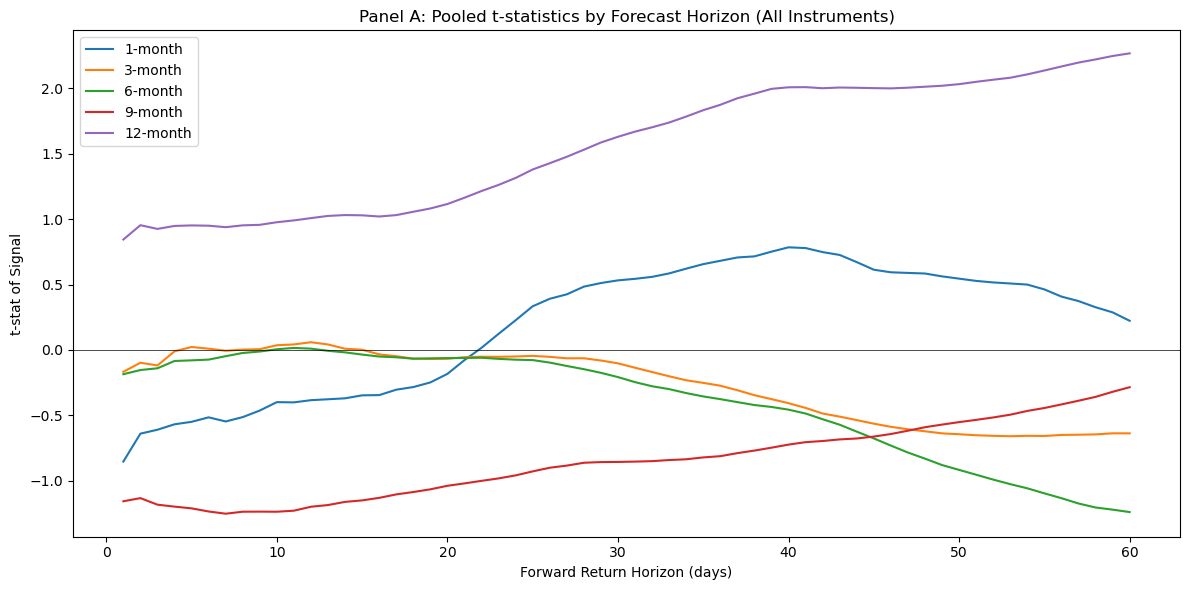

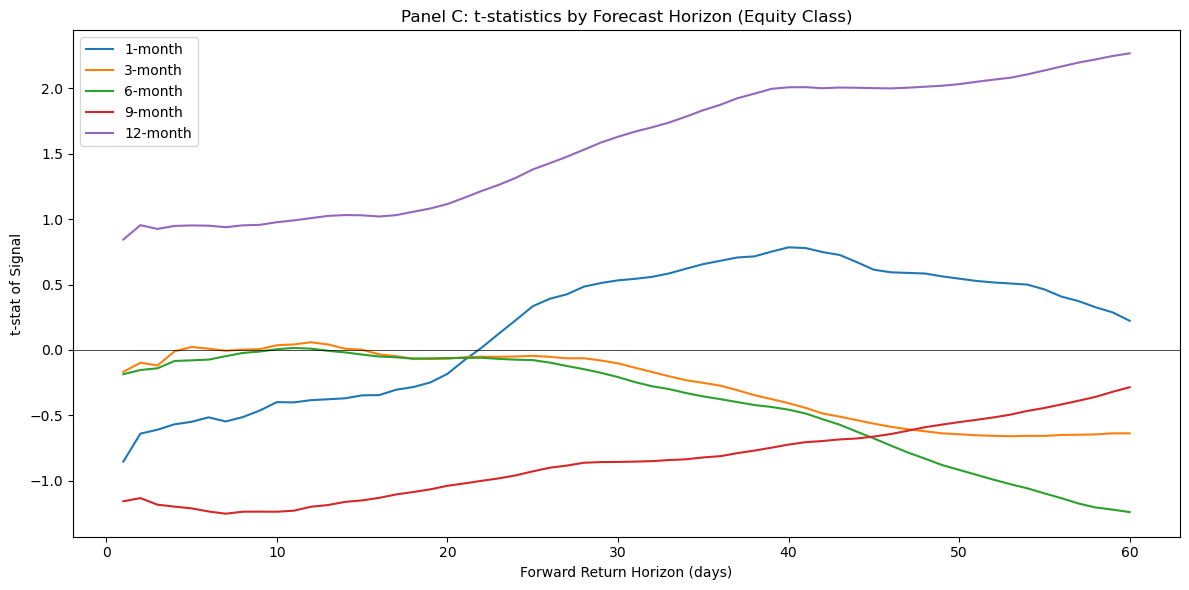

In [13]:
# Reorganize results for accurate Panel A and Panel C as per the paper

# Step 1: Redo pooled regressions for Panel A (pooled across all instruments and all asset classes)
panel_a_corrected = []

# Use only Equity for now (SPX, Nikkei) — extendable later
all_assets_df = []
returns = compute_log_returns(df_equity)
volatility = returns.rolling(window=vol_window).std()

for h in horizon_days:
    for k in k_months:
        lookback_days = k * trading_days_per_month

        signal = returns.rolling(window=lookback_days).sum() / volatility
        signal = signal.shift(1)
        forward_returns = np.log(df_equity.shift(-h) / df_equity)

        df_list = []
        for asset in df_equity.columns:
            df_tmp = pd.DataFrame({
                'Return': forward_returns[asset],
                'Signal': signal[asset],
                'Date': df_equity.index,
                'Asset': asset
            }).dropna()
            df_list.append(df_tmp)

        df_all = pd.concat(df_list)
        df_all['Month'] = df_all['Date'].dt.to_period('M')
        df_all['Intercept'] = 1

        # Pooled regression across all instruments
        clusters = df_all['Month'].astype(str)
        model = sm.OLS(df_all['Return'], df_all[['Intercept', 'Signal']])
        result = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})
        panel_a_corrected.append({'h': h, 'k': k, 'tstat': result.tvalues['Signal']})

df_panel_a_corrected = pd.DataFrame(panel_a_corrected)

# Step 2: Redo regressions for Panel C — aggregated by asset class (Equity only for now)
panel_c_by_class = {'Equity': []}

for h in horizon_days:
    for k in k_months:
        lookback_days = k * trading_days_per_month

        signal = returns.rolling(window=lookback_days).sum() / volatility
        signal = signal.shift(1)
        forward_returns = np.log(df_equity.shift(-h) / df_equity)

        df_list = []
        for asset in df_equity.columns:
            df_tmp = pd.DataFrame({
                'Return': forward_returns[asset],
                'Signal': signal[asset],
                'Date': df_equity.index,
                'Asset': asset
            }).dropna()
            df_list.append(df_tmp)

        df_all = pd.concat(df_list)
        df_all['Month'] = df_all['Date'].dt.to_period('M')
        df_all['Intercept'] = 1

        clusters = df_all['Month'].astype(str)
        model = sm.OLS(df_all['Return'], df_all[['Intercept', 'Signal']])
        result = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})
        panel_c_by_class['Equity'].append({'h': h, 'k': k, 'tstat': result.tvalues['Signal']})

df_panel_c_equity = pd.DataFrame(panel_c_by_class['Equity'])

# Plot updated Panel A: Pooled regression across all instruments
fig, ax = plt.subplots(figsize=(12, 6))
for k in k_months:
    df_k = df_panel_a_corrected[df_panel_a_corrected['k'] == k]
    ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Panel A: Pooled t-statistics by Forecast Horizon (All Instruments)')
ax.set_xlabel('Forward Return Horizon (days)')
ax.set_ylabel('t-stat of Signal')
ax.legend()
plt.tight_layout()
plt.show()

# Plot updated Panel C: Per asset class (Equity)
fig, ax = plt.subplots(figsize=(12, 6))
for k in k_months:
    df_k = df_panel_c_equity[df_panel_c_equity['k'] == k]
    ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Panel C: t-statistics by Forecast Horizon (Equity Class)')
ax.set_xlabel('Forward Return Horizon (days)')
ax.set_ylabel('t-stat of Signal')
ax.legend()
plt.tight_layout()
plt.show()


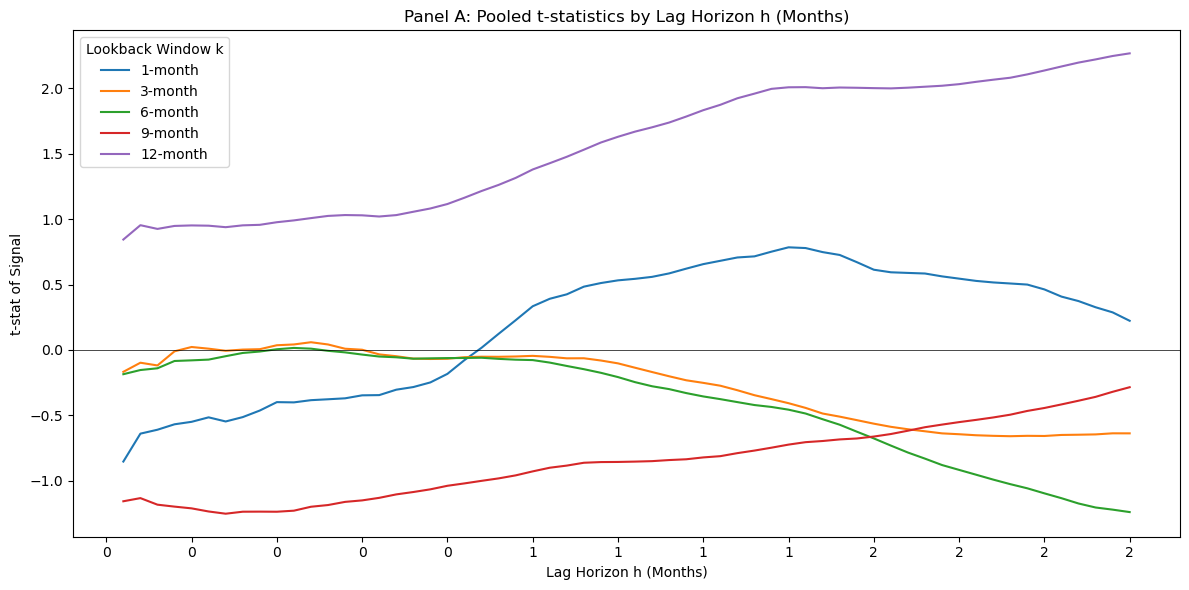

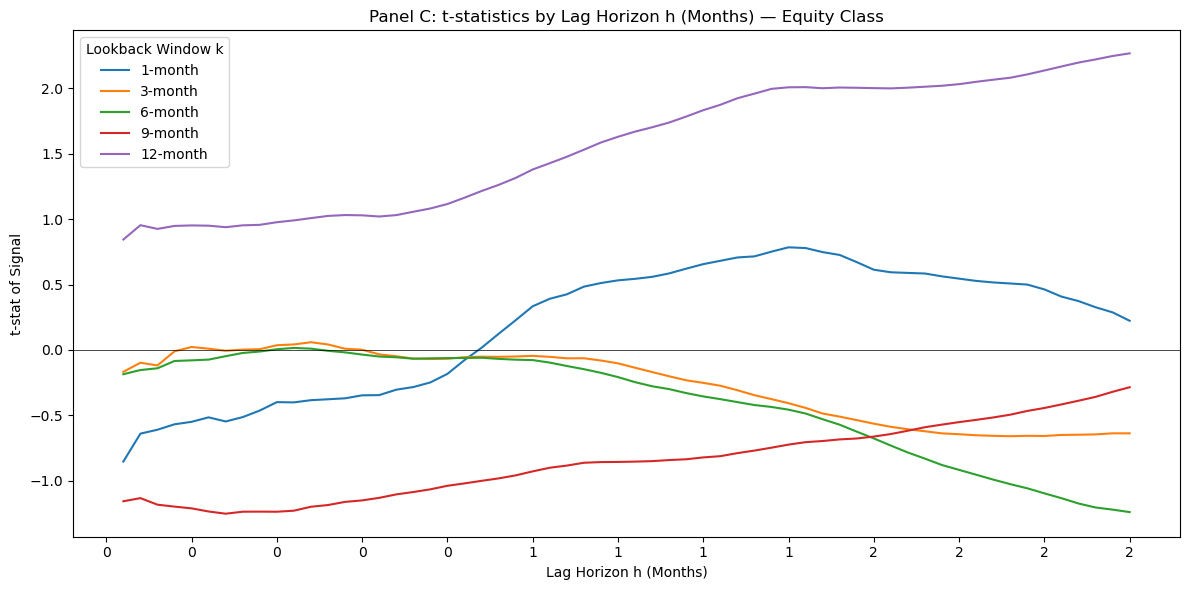

In [15]:
# Update plots: Correct the x-axis to reflect lag (h) in months instead of forward return horizon

# Plot updated Panel A: Pooled regression across all instruments (x-axis = lag in months)
fig, ax = plt.subplots(figsize=(12, 6))
for k in k_months:
    df_k = df_panel_a_corrected[df_panel_a_corrected['k'] == k]
    ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Panel A: Pooled t-statistics by Lag Horizon h (Months)')
ax.set_xlabel('Lag Horizon h (Months)')
ax.set_ylabel('t-stat of Signal')
ax.legend(title="Lookback Window k")
ax.set_xticks(range(0, 61, 5))
ax.set_xticklabels([f"{x//21}" for x in range(0, 61, 5)])
plt.tight_layout()
plt.show()

# Plot updated Panel C: Per asset class (Equity only), x-axis = lag h in months
fig, ax = plt.subplots(figsize=(12, 6))
for k in k_months:
    df_k = df_panel_c_equity[df_panel_c_equity['k'] == k]
    ax.plot(df_k['h'], df_k['tstat'], label=f'{k}-month')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Panel C: t-statistics by Lag Horizon h (Months) — Equity Class')
ax.set_xlabel('Lag Horizon h (Months)')
ax.set_ylabel('t-stat of Signal')
ax.legend(title="Lookback Window k")
ax.set_xticks(range(0, 61, 5))
ax.set_xticklabels([f"{x//21}" for x in range(0, 61, 5)])
plt.tight_layout()
plt.show()


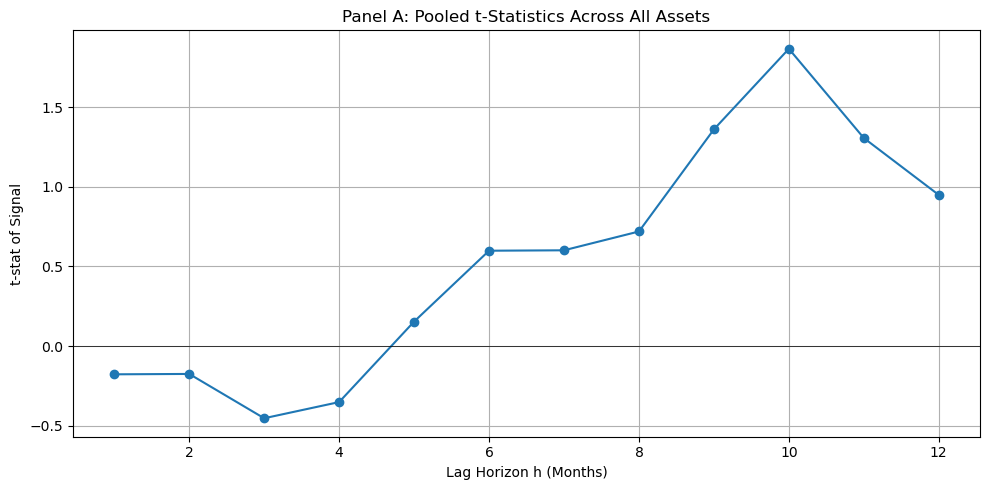

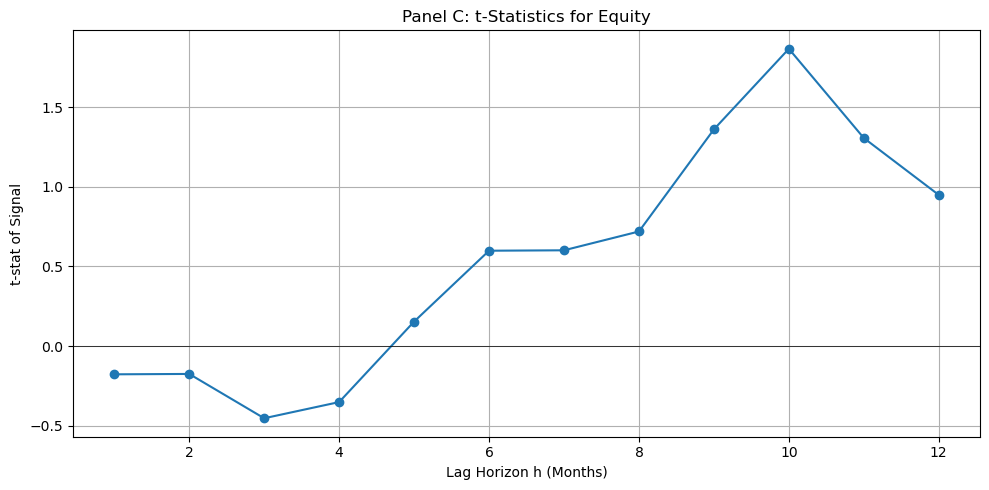

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Simulate 5 years of daily data for SPX and Nikkei
np.random.seed(0)
dates = pd.bdate_range(start="2018-01-01", end="2023-01-01")
n_days = len(dates)

def simulate_prices(n, drift=0.0002, vol=0.01):
    returns = np.random.normal(drift, vol, n)
    return 100 * np.exp(np.cumsum(returns))

spx = simulate_prices(n_days)
nikkei = simulate_prices(n_days, drift=0.0001, vol=0.012)

df_equity = pd.DataFrame({'SPX': spx, 'Nikkei': nikkei}, index=dates)

# Organize in the specified dictionary format
data = {
    'Equity': df_equity,
    'FX': pd.DataFrame(),
    'Commodity': pd.DataFrame(),
    'IRS': pd.DataFrame()
}

# Parameters
vol_window = 60
h_months = list(range(1, 13))
trading_days_per_month = 21
forward_return_horizon = trading_days_per_month

# Compute daily log returns
returns = {asset_class: np.log(df / df.shift(1)) for asset_class, df in data.items()}

# Compute rolling volatility
volatility = {asset_class: ret.rolling(vol_window).std() for asset_class, ret in returns.items()}

# Panel A: pooled t-stats across all assets
panel_a = []

# Panel C: t-stats by asset class
panel_c = {ac: [] for ac in data.keys() if not data[ac].empty}

for h in h_months:
    lookback_days = h * trading_days_per_month

    pooled_data = []
    class_data = {ac: [] for ac in panel_c}

    for asset_class, df_prices in data.items():
        if df_prices.empty:
            continue

        df_returns = returns[asset_class]
        df_vol = volatility[asset_class]

        # Rolling past h-month return
        signal = df_returns.rolling(lookback_days).sum() / df_vol
        signal = signal.shift(1)

        # 1-month forward return
        forward_return = np.log(df_prices.shift(-forward_return_horizon) / df_prices)

        for instrument in df_prices.columns:
            df = pd.DataFrame({
                'Return': forward_return[instrument],
                'Signal': signal[instrument],
                'Date': df_prices.index,
                'Asset': instrument
            }).dropna()
            df['Month'] = df['Date'].dt.to_period('M')
            df['Intercept'] = 1
            pooled_data.append(df)
            class_data[asset_class].append(df)

    # Pooled regression (Panel A)
    df_pooled = pd.concat(pooled_data)
    clusters = df_pooled['Month'].astype(str)
    model = sm.OLS(df_pooled['Return'], df_pooled[['Intercept', 'Signal']])
    result = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})
    panel_a.append({'h': h, 'tstat': result.tvalues['Signal']})

    # Class-wise regressions (Panel C)
    for asset_class, dfs in class_data.items():
        df_all = pd.concat(dfs)
        clusters = df_all['Month'].astype(str)
        model = sm.OLS(df_all['Return'], df_all[['Intercept', 'Signal']])
        result = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})
        panel_c[asset_class].append({'h': h, 'tstat': result.tvalues['Signal']})

# Convert to DataFrame
df_panel_a = pd.DataFrame(panel_a)
df_panel_c = {k: pd.DataFrame(v) for k, v in panel_c.items()}

# Plot Panel A
plt.figure(figsize=(10, 5))
plt.plot(df_panel_a['h'], df_panel_a['tstat'], marker='o')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Panel A: Pooled t-Statistics Across All Assets')
plt.xlabel('Lag Horizon h (Months)')
plt.ylabel('t-stat of Signal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Panel C
for asset_class, df_c in df_panel_c.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df_c['h'], df_c['tstat'], marker='o')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title(f'Panel C: t-Statistics for {asset_class}')
    plt.xlabel('Lag Horizon h (Months)')
    plt.ylabel('t-stat of Signal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


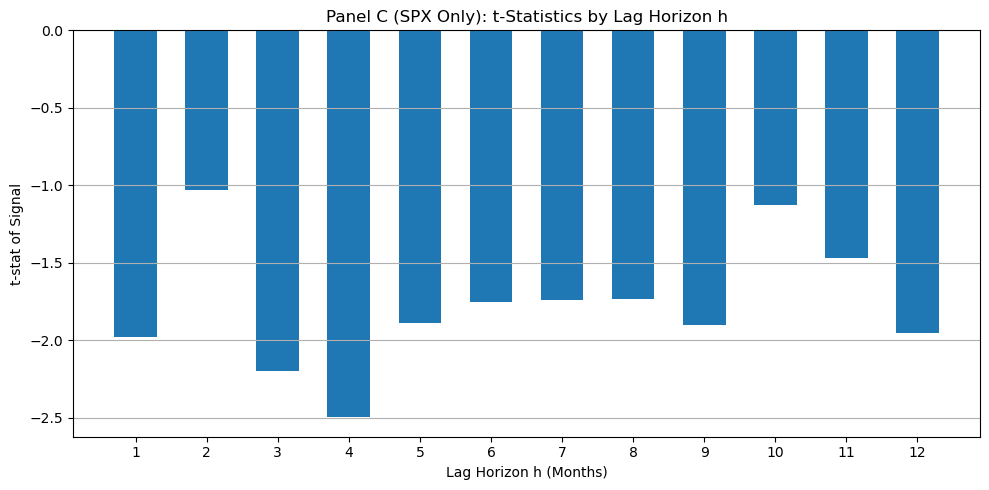

In [21]:
# Filter data for SPX only
asset_class = 'Equity'
df_equity_returns = returns[asset_class]
df_equity_vol = volatility[asset_class]
df_equity_prices = data[asset_class]

instrument = 'Nikkei'
spx_panel_c = []

for h in h_months:
    lookback_days = h * trading_days_per_month

    signal = df_equity_returns.rolling(lookback_days).sum() / df_equity_vol
    signal = signal.shift(1)

    forward_return = np.log(df_equity_prices.shift(-forward_return_horizon) / df_equity_prices)

    df = pd.DataFrame({
        'Return': forward_return[instrument],
        'Signal': signal[instrument],
        'Date': df_equity_prices.index
    }).dropna()

    df['Month'] = df['Date'].dt.to_period('M')
    df['Intercept'] = 1

    clusters = df['Month'].astype(str)
    model = sm.OLS(df['Return'], df[['Intercept', 'Signal']])
    result = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})
    spx_panel_c.append({'h': h, 'tstat': result.tvalues['Signal']})

# Plot SPX t-stats as bar chart
df_spx = pd.DataFrame(spx_panel_c)
plt.figure(figsize=(10, 5))
plt.bar(df_spx['h'], df_spx['tstat'], width=0.6)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Panel C (SPX Only): t-Statistics by Lag Horizon h')
plt.xlabel('Lag Horizon h (Months)')
plt.ylabel('t-stat of Signal')
plt.xticks(df_spx['h'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


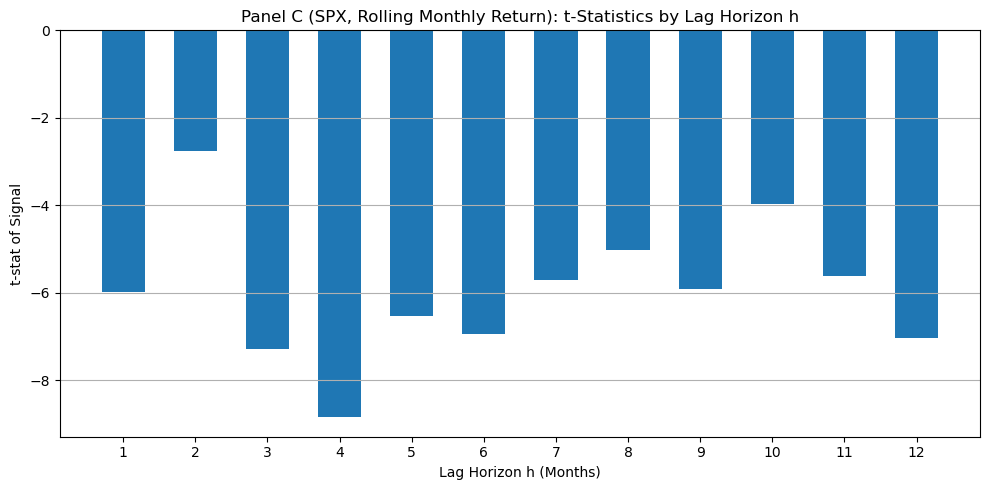

In [25]:
# Re-implement using rolling monthly returns instead of resampled month-end data
# This maintains daily continuity while computing monthly signals

# Parameters
h_months = list(range(1, 13))
monthly_days = 21
annualization_factor = np.sqrt(12)

# Compute daily log returns
daily_prices = df_equity['Nikkei']
daily_returns = np.log(daily_prices / daily_prices.shift(1))

# Container for t-stats
tstats_spx_rolling = []

for h in h_months:
    lookback_days = h * monthly_days

    # Rolling cumulative return over past h months
    past_cum_return = daily_returns.rolling(window=lookback_days).sum()

    # Rolling std dev over h months (same window), annualized
    rolling_vol = daily_returns.rolling(window=lookback_days).std()
    annualized_vol = rolling_vol * annualization_factor

    # Signal: scaled cumulative return
    signal = past_cum_return / annualized_vol

    # Align signal at time t with return at t+1 month
    forward_return = daily_prices.shift(-monthly_days)
    forward_return = np.log(forward_return / daily_prices)

    df = pd.DataFrame({
        'Signal': signal,
        'Return': forward_return
    }).dropna()

    if len(df) > 0:
        df['Intercept'] = 1
        model = sm.OLS(df['Return'], df[['Intercept', 'Signal']])
        result = model.fit()
        tstats_spx_rolling.append({'h': h, 'tstat': result.tvalues['Signal']})
    else:
        tstats_spx_rolling.append({'h': h, 'tstat': np.nan})

# Plot the corrected t-stats using rolling monthly return signals
df_spx_rolling = pd.DataFrame(tstats_spx_rolling)
plt.figure(figsize=(10, 5))
plt.bar(df_spx_rolling['h'], df_spx_rolling['tstat'], width=0.6)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Panel C (SPX, Rolling Monthly Return): t-Statistics by Lag Horizon h')
plt.xlabel('Lag Horizon h (Months)')
plt.ylabel('t-stat of Signal')
plt.xticks(df_spx_rolling['h'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


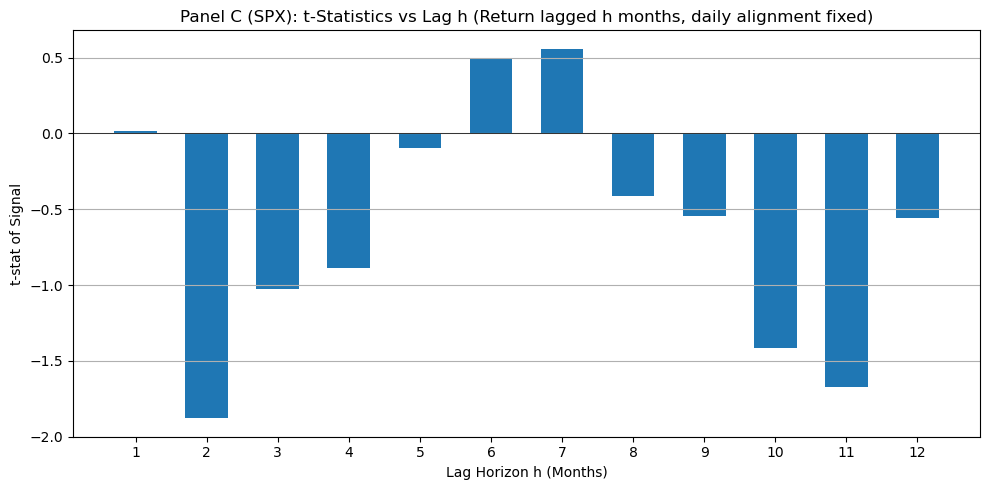

In [27]:
# Fixing the timestamp alignment using valid trading days only

# Step 1: Identify last available trading day of each month in the SPX price data
month_ends_valid = daily_prices.groupby([daily_prices.index.year, daily_prices.index.month]).idxmax()
month_end_prices = daily_prices.loc[month_ends_valid.values]
month_end_idx = month_end_prices.index

# Compute 1-month simple returns
monthly_simple_returns = month_end_prices.pct_change().dropna()

# Step 2: Build the regression input
tstats_fixed = []

for h in h_months:
    regression_data = []

    for t in range(h + 1, len(month_end_prices) - 1):
        date_t = month_end_idx[t]
        date_t_plus_1 = month_end_idx[t + 1]
        date_t_minus_h = month_end_idx[t - h]
        date_t_minus_h_minus_1 = month_end_idx[t - h - 1]

        # Dependent variable: return at t+1
        r_t_plus_1 = (month_end_prices[date_t_plus_1] / month_end_prices[date_t]) - 1

        # Predictor: return lagged h months
        r_t_minus_h = (month_end_prices[date_t_minus_h] / month_end_prices[date_t_minus_h_minus_1]) - 1

        # Volatility from t-h to t (daily returns), annualized
        start_idx = dates.get_loc(date_t_minus_h)
        end_idx = dates.get_loc(date_t)
        returns_window = daily_returns.iloc[start_idx:end_idx]
        sigma = returns_window.std() * annualization_factor

        if pd.notnull(r_t_plus_1) and pd.notnull(r_t_minus_h) and pd.notnull(sigma) and sigma != 0:
            signal = r_t_minus_h / sigma
            regression_data.append((r_t_plus_1, signal))

    # Run regression
    if len(regression_data) > 0:
        df_reg = pd.DataFrame(regression_data, columns=["Return", "Signal"])
        df_reg["Intercept"] = 1
        model = sm.OLS(df_reg["Return"], df_reg[["Intercept", "Signal"]])
        result = model.fit()
        tstats_fixed.append({"h": h, "tstat": result.tvalues["Signal"]})
    else:
        tstats_fixed.append({"h": h, "tstat": np.nan})

# Step 3: Plot
df_tstats = pd.DataFrame(tstats_fixed)
plt.figure(figsize=(10, 5))
plt.bar(df_tstats['h'], df_tstats['tstat'], width=0.6)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Panel C (SPX): t-Statistics vs Lag h (Return lagged h months, daily alignment fixed)')
plt.xlabel('Lag Horizon h (Months)')
plt.ylabel('t-stat of Signal')
plt.xticks(df_tstats['h'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


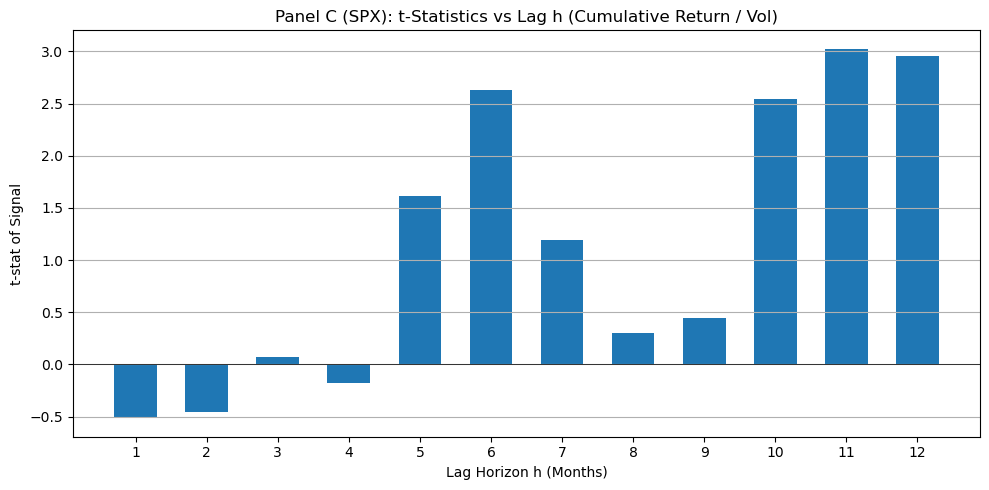

In [29]:
# Re-implementing based on clarified logic:
# ✅ Input: Dictionary with asset classes as keys, each containing a DataFrame of prices (e.g., SPX, Nikkei)
# ✅ Signal: Cumulative return over h months (not a 1-month lagged return)
# ✅ Volatility: Estimated over same h-month window, annualized
# ✅ Regression: 1-month forward return ~ signal (cumulative return / vol)

# Simulate price data again for SPX and Nikkei to match input structure
np.random.seed(42)
dates = pd.bdate_range(start="2018-01-01", end="2023-01-01")
n_days = len(dates)

def simulate_prices(n, drift=0.0002, vol=0.01):
    returns = np.random.normal(drift, vol, n)
    return 100 * np.exp(np.cumsum(returns))

df_equity = pd.DataFrame({
    'SPX': simulate_prices(n_days),
    'Nikkei': simulate_prices(n_days, drift=0.0001, vol=0.012)
}, index=dates)

data = {
    'Equity': df_equity,
    'FX': pd.DataFrame(),
    'Commodity': pd.DataFrame(),
    'IRS': pd.DataFrame()
}

# Parameters
h_months = list(range(1, 13))
monthly_days = 21
annualization_factor = np.sqrt(12)

# Output container
results = []

for asset_class, df_prices in data.items():
    if df_prices.empty:
        continue

    df_returns = df_prices.pct_change()
    for instrument in df_prices.columns:
        prices = df_prices[instrument]
        returns = df_returns[instrument]

        instrument_results = []
        for h in h_months:
            lookback_days = h * monthly_days

            # Cumulative return over past h months
            cum_return = prices.pct_change(periods=lookback_days)

            # Volatility over past h months, annualized
            vol = returns.rolling(window=lookback_days).std() * annualization_factor

            # Signal = cumulative return / vol
            signal = cum_return / vol

            # Forward 1-month return
            forward_return = prices.pct_change(periods=monthly_days).shift(-monthly_days)

            # Align and regress
            df = pd.DataFrame({
                'Return': forward_return,
                'Signal': signal
            }).dropna()

            if not df.empty:
                df['Intercept'] = 1
                model = sm.OLS(df['Return'], df[['Intercept', 'Signal']])
                result = model.fit()
                t_stat = result.tvalues['Signal']
            else:
                t_stat = np.nan

            instrument_results.append({'Instrument': instrument, 'AssetClass': asset_class, 'h': h, 'tstat': t_stat})

        results.extend(instrument_results)

# Convert to DataFrame for plotting
df_results = pd.DataFrame(results)

# Plot Panel C-style for SPX
df_spx = df_results[df_results['Instrument'] == 'SPX']
plt.figure(figsize=(10, 5))
plt.bar(df_spx['h'], df_spx['tstat'], width=0.6)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Panel C (SPX): t-Statistics vs Lag h (Cumulative Return / Vol)')
plt.xlabel('Lag Horizon h (Months)')
plt.ylabel('t-stat of Signal')
plt.xticks(df_spx['h'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Processing Equity...


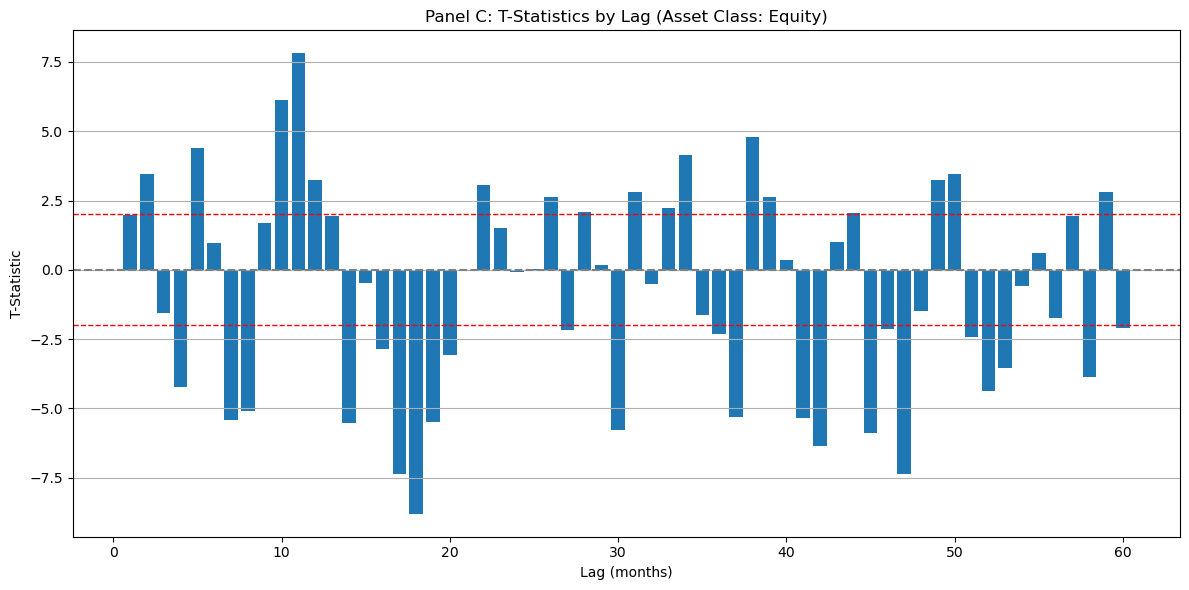

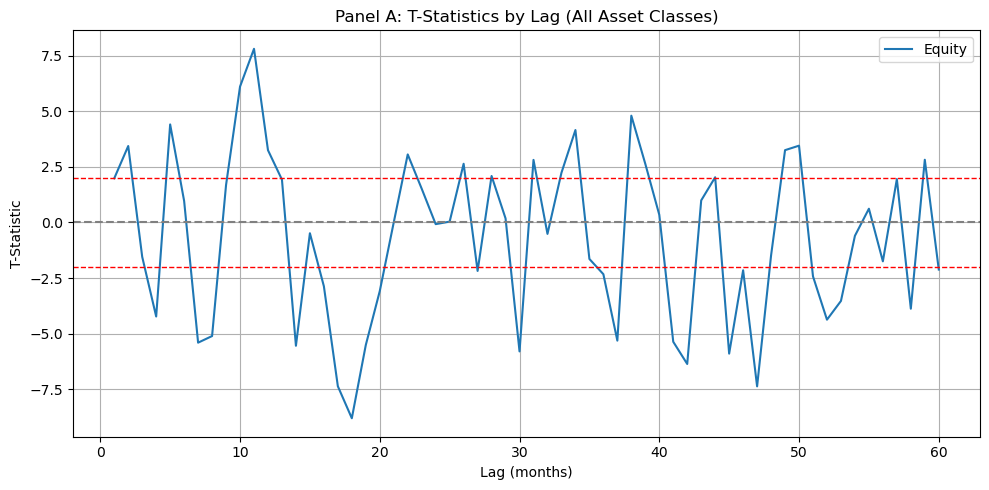

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# === CONFIGURATION ===
rolling_window = 21  # ~1 month = 21 trading days
max_lag_months = 60

# === INPUT DATA STRUCTURE ===
# Assume `data` is a dictionary with keys as asset classes
# and values as DataFrames (index: daily dates, columns: instruments)
# Example:
# data = {
#     "Equity": pd.DataFrame(...),
#     "IRS": pd.DataFrame(...),
#     "FX": pd.DataFrame(...),
#     "Commodity": pd.DataFrame(...)
# }

# === PROCESSING FUNCTION ===
def prepare_regression_data(asset_class, df):
    daily_returns = df.pct_change()
    rolling_returns = df.pct_change(periods=rolling_window)
    rolling_vol = daily_returns.rolling(window=rolling_window).std()

    regression_rows = []

    for h in range(1, max_lag_months + 1):
        lag_days = h * rolling_window
        for instrument in df.columns:
            r_t = rolling_returns[instrument]
            r_t_h = r_t.shift(lag_days)
            sigma_t = rolling_vol[instrument].shift(1)
            sigma_t_h = rolling_vol[instrument].shift(lag_days + 1)

            y_t = r_t / sigma_t
            x_t_h = r_t_h / sigma_t_h

            temp_df = pd.DataFrame({
                "Date": r_t.index,
                "AssetClass": asset_class,
                "Instrument": instrument,
                "y_t": y_t,
                "x_t_h": x_t_h,
                "h": h
            }).dropna()

            regression_rows.append(temp_df)

    return pd.concat(regression_rows, ignore_index=True) if regression_rows else pd.DataFrame()

# === REGRESSION FUNCTION ===
def run_panel_regression(df):
    results = []
    for h, group in df.groupby("h"):
        if len(group) < 10:
            continue
        X = sm.add_constant(group["x_t_h"])
        y = group["y_t"]
        model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': group['Date']})
        beta = model.params.get("x_t_h", np.nan)
        t_stat = model.tvalues.get("x_t_h", np.nan)
        results.append({"h": h, "beta": beta, "t_stat": t_stat})
    return pd.DataFrame(results)

# === PLOTTING FUNCTIONS ===
def plot_panel_c(results_df, asset_class):
    plt.figure(figsize=(12, 6))
    plt.bar(results_df["h"], results_df["t_stat"], width=0.8)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
    plt.title(f"Panel C: T-Statistics by Lag (Asset Class: {asset_class})")
    plt.xlabel("Lag (months)")
    plt.ylabel("T-Statistic")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

def plot_panel_a(panel_results):
    plt.figure(figsize=(10, 5))
    for asset_class, df in panel_results.items():
        if df.empty: continue
        plt.plot(df["h"], df["t_stat"], label=asset_class)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
    plt.title("Panel A: T-Statistics by Lag (All Asset Classes)")
    plt.xlabel("Lag (months)")
    plt.ylabel("T-Statistic")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === MAIN WORKFLOW ===
panel_results = {}

for asset_class, df in data.items():
    if df.empty:
        panel_results[asset_class] = pd.DataFrame()
        continue
    print(f"Processing {asset_class}...")
    regression_df = prepare_regression_data(asset_class, df)
    results_df = run_panel_regression(regression_df)
    panel_results[asset_class] = results_df
    plot_panel_c(results_df, asset_class)

plot_panel_a(panel_results)  # Combined view


Processing Equity...


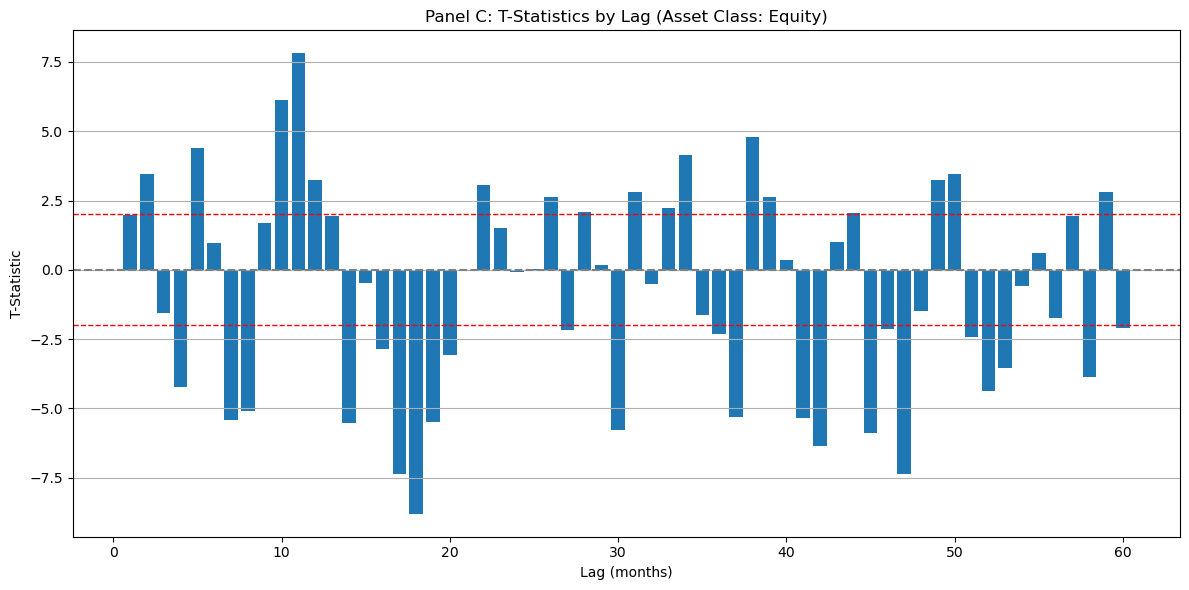

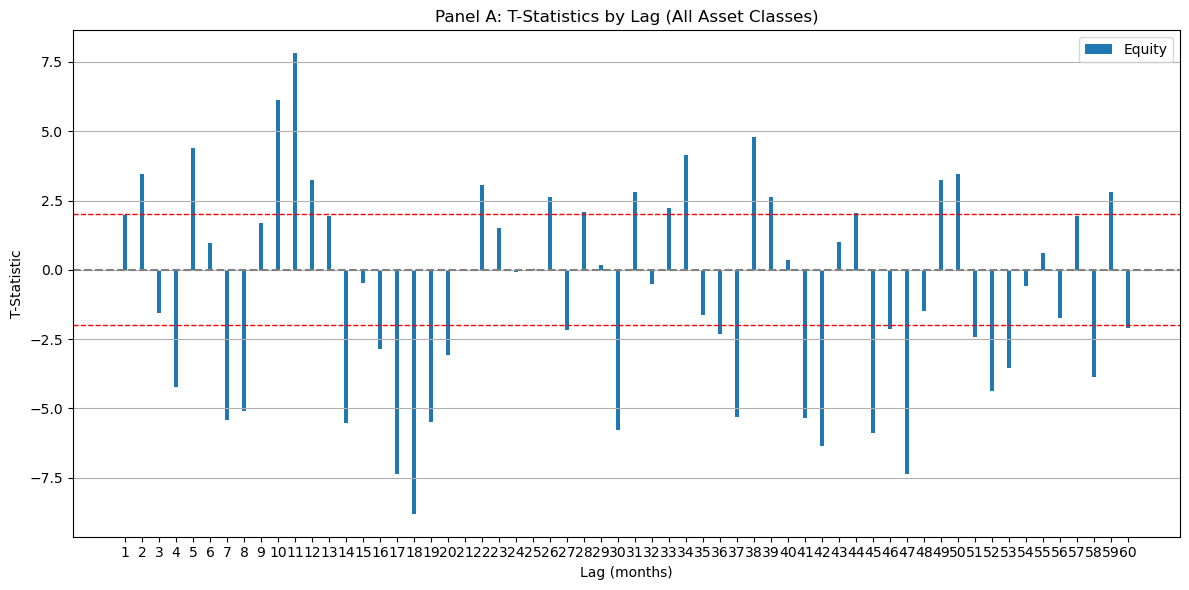

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# === CONFIGURATION ===
rolling_window = 21  # ~1 month = 21 trading days
max_lag_months = 60

# === INPUT DATA STRUCTURE ===
# Assume `data` is a dictionary with keys as asset classes
# and values as DataFrames (index: daily dates, columns: instruments)

# === PROCESSING ===
panel_results = {}

for asset_class, df in data.items():
    if df.empty:
        panel_results[asset_class] = pd.DataFrame()
        continue

    print(f"Processing {asset_class}...")

    daily_returns = df.pct_change()
    rolling_returns = df.pct_change(periods=rolling_window)
    rolling_vol = daily_returns.rolling(window=rolling_window).std()

    regression_rows = []

    for h in range(1, max_lag_months + 1):
        lag_days = h * rolling_window
        for instrument in df.columns:
            r_t = rolling_returns[instrument]
            r_t_h = r_t.shift(lag_days)
            sigma_t = rolling_vol[instrument].shift(1)
            sigma_t_h = rolling_vol[instrument].shift(lag_days + 1)

            y_t = r_t / sigma_t
            x_t_h = r_t_h / sigma_t_h

            temp_df = pd.DataFrame({
                "Date": r_t.index,
                "AssetClass": asset_class,
                "Instrument": instrument,
                "y_t": y_t,
                "x_t_h": x_t_h,
                "h": h
            }).dropna()

            regression_rows.append(temp_df)

    if not regression_rows:
        panel_results[asset_class] = pd.DataFrame()
        continue

    regression_df = pd.concat(regression_rows, ignore_index=True)

    results = []
    for h, group in regression_df.groupby("h"):
        if len(group) < 10:
            continue
        X = sm.add_constant(group["x_t_h"])
        y = group["y_t"]
        model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': group['Date']})
        beta = model.params.get("x_t_h", np.nan)
        t_stat = model.tvalues.get("x_t_h", np.nan)
        results.append({"h": h, "beta": beta, "t_stat": t_stat})

    results_df = pd.DataFrame(results)
    panel_results[asset_class] = results_df

    # === PANEL C PLOT ===
    plt.figure(figsize=(12, 6))
    plt.bar(results_df["h"], results_df["t_stat"], width=0.8)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
    plt.title(f"Panel C: T-Statistics by Lag (Asset Class: {asset_class})")
    plt.xlabel("Lag (months)")
    plt.ylabel("T-Statistic")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# === PANEL A PLOT ===
plt.figure(figsize=(12, 6))
h_labels = None
bar_width = 0.2
for i, (asset_class, df) in enumerate(panel_results.items()):
    if df.empty:
        continue
    x = df["h"] + (i * bar_width)  # offset bars
    plt.bar(x, df["t_stat"], width=bar_width, label=asset_class)
    h_labels = df["h"]

plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
plt.title("Panel A: T-Statistics by Lag (All Asset Classes)")
plt.xlabel("Lag (months)")
plt.ylabel("T-Statistic")
plt.xticks(ticks=h_labels)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Processing Equity...


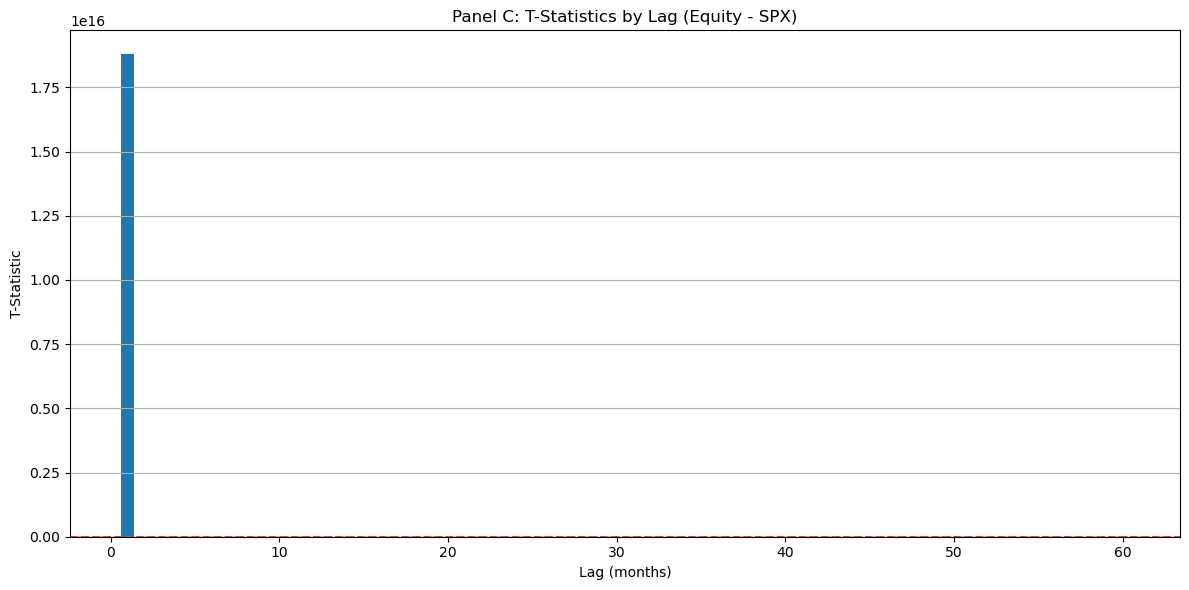

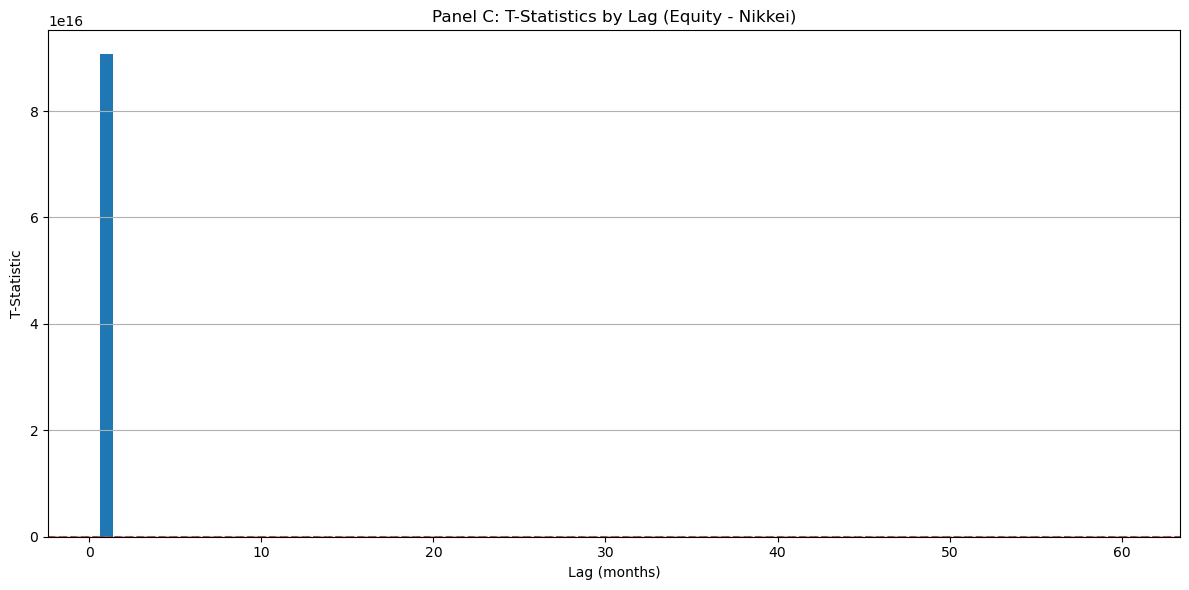

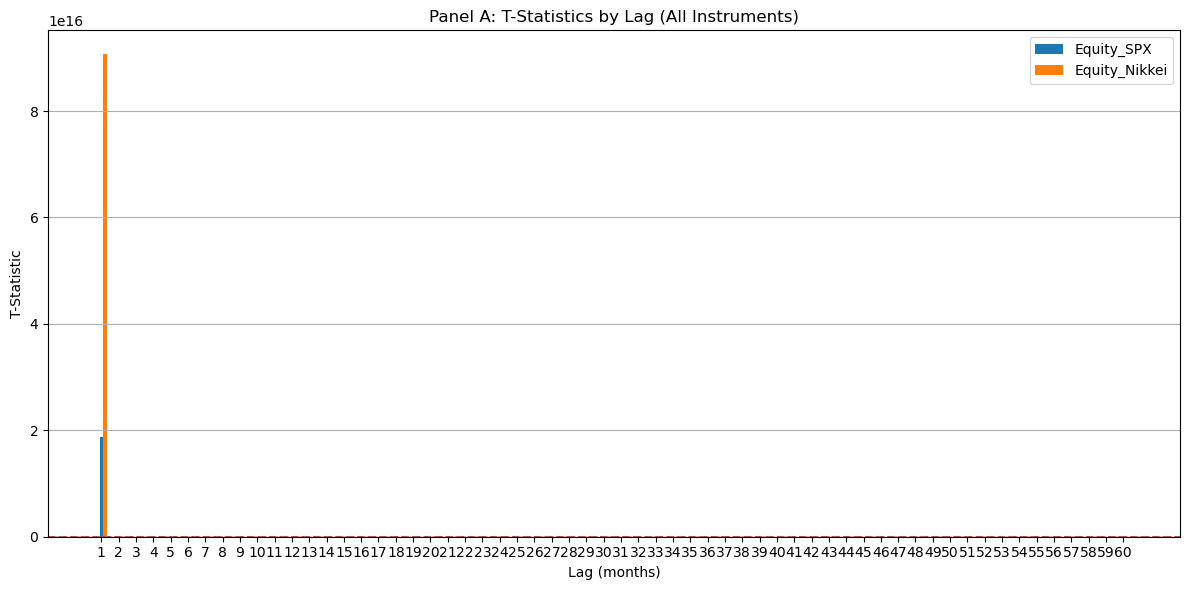

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# === CONFIGURATION ===
rolling_window = 21  # 1 month ~ 21 trading days
max_lag_months = 60

# === INPUT DATA STRUCTURE ===
# data = {
#     "Equity": pd.DataFrame(...),
#     "IRS": pd.DataFrame(...),
#     "FX": pd.DataFrame(...),
#     "Commodity": pd.DataFrame(...)
# }

panel_results = {}

for asset_class, df in data.items():
    if df.empty:
        panel_results[asset_class] = pd.DataFrame()
        continue

    print(f"Processing {asset_class}...")
    for instrument in df.columns:
        price_series = df[instrument]
        daily_ret_series = price_series.pct_change()

        # Target: 1-month return and volatility
        target_return = price_series.pct_change(periods=rolling_window)
        target_vol = daily_ret_series.rolling(window=rolling_window).std() * np.sqrt(252)
        target_scaled_return = target_return / target_vol

        regression_rows = []
        for h in range(1, max_lag_months + 1):
            lag_window = h * rolling_window
            cumulative_return = price_series.pct_change(periods=lag_window)
            lag_vol = daily_ret_series.rolling(window=lag_window).std() * np.sqrt(252)
            lagged_scaled_return = cumulative_return / lag_vol

            temp_df = pd.DataFrame({
                "Date": price_series.index,
                "AssetClass": asset_class,
                "Instrument": instrument,
                "y_t": target_scaled_return,
                "x_t_h": lagged_scaled_return,
                "h": h
            }).dropna()

            regression_rows.append(temp_df)

        if not regression_rows:
            continue

        regression_df = pd.concat(regression_rows, ignore_index=True)

        results = []
        for h, group in regression_df.groupby("h"):
            if len(group) < 10:
                continue
            X = sm.add_constant(group["x_t_h"])
            y = group["y_t"]
            model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': group['Date']})
            beta = model.params.get("x_t_h", np.nan)
            t_stat = model.tvalues.get("x_t_h", np.nan)
            results.append({"h": h, "beta": beta, "t_stat": t_stat})

        results_df = pd.DataFrame(results)
        key = f"{asset_class}_{instrument}"
        panel_results[key] = results_df

        # Panel C: individual instrument
        plt.figure(figsize=(12, 6))
        plt.bar(results_df["h"], results_df["t_stat"], width=0.8)
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
        plt.title(f"Panel C: T-Statistics by Lag ({asset_class} - {instrument})")
        plt.xlabel("Lag (months)")
        plt.ylabel("T-Statistic")
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

# Panel A: Compare instruments across asset classes
plt.figure(figsize=(12, 6))
h_labels = None
bar_width = 0.2
for i, (label, df) in enumerate(panel_results.items()):
    if df.empty: continue
    x = df["h"] + (i * bar_width)
    plt.bar(x, df["t_stat"], width=bar_width, label=label)
    h_labels = df["h"]

plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
plt.title("Panel A: T-Statistics by Lag (All Instruments)")
plt.xlabel("Lag (months)")
plt.ylabel("T-Statistic")
plt.xticks(ticks=h_labels)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



Processing Equity...


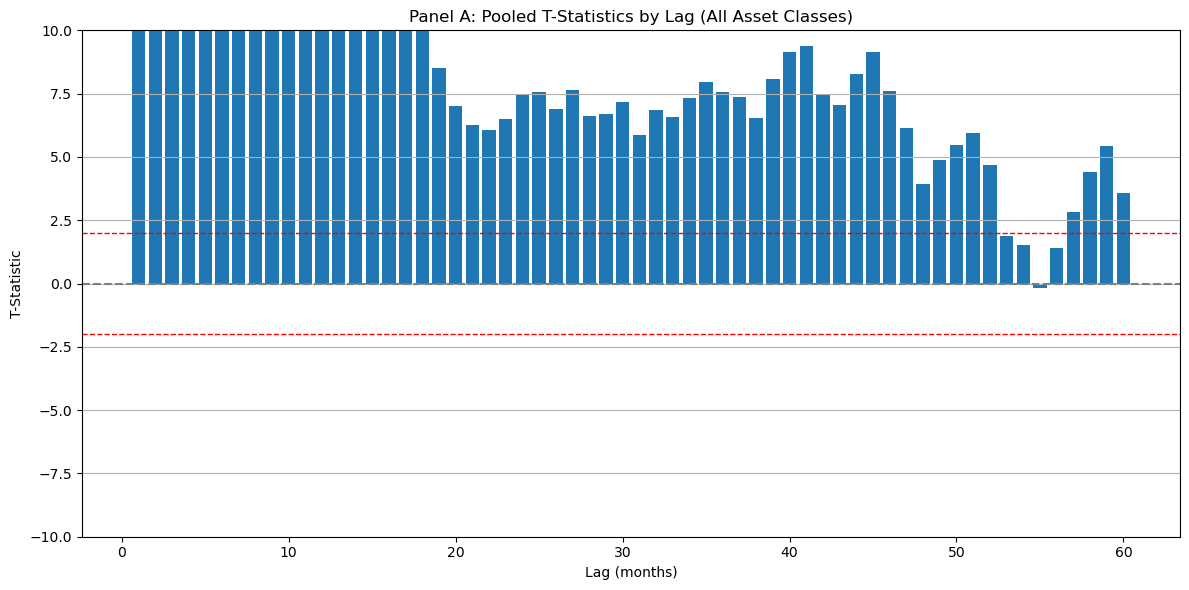

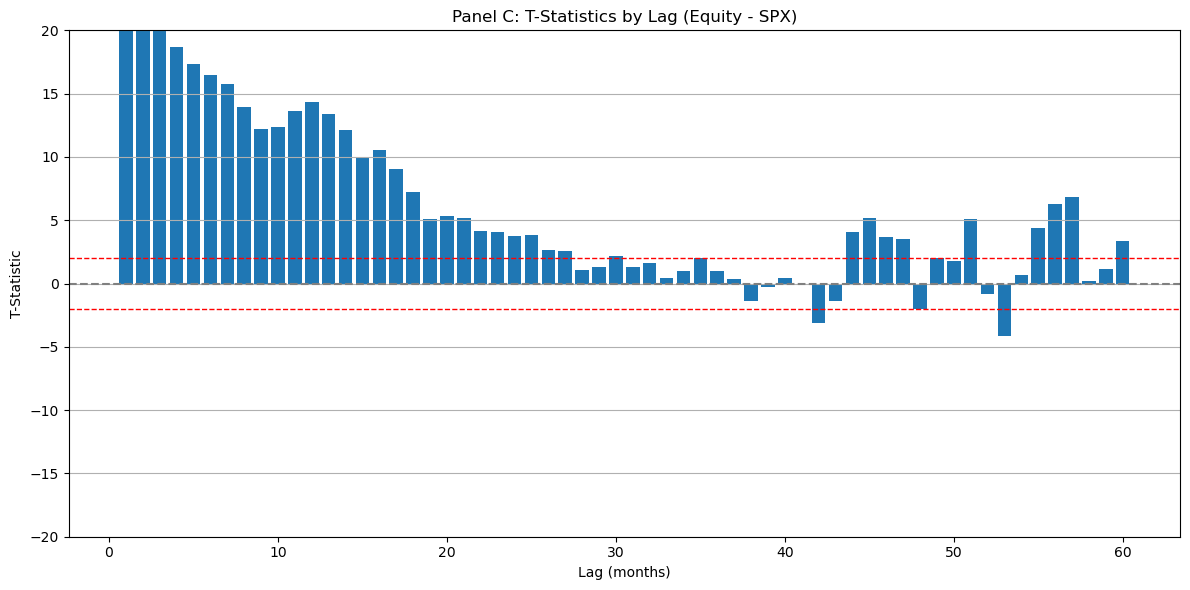

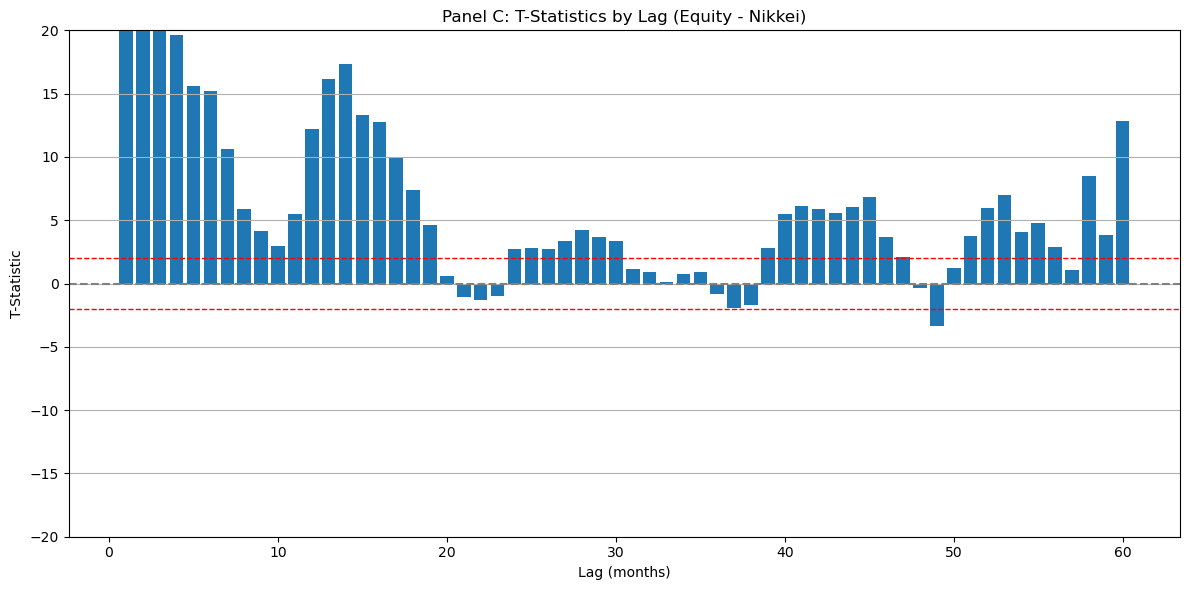

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# === CONFIGURATION ===
rolling_window = 21  # 1 month ~ 21 trading days
max_lag_months = 60

# === INPUT DATA STRUCTURE ===
# data = {
#     "Equity": pd.DataFrame(...),
#     "IRS": pd.DataFrame(...),
#     "FX": pd.DataFrame(...),
#     "Commodity": pd.DataFrame(...)
# }

all_regression_rows = []

for asset_class, df in data.items():
    if df.empty:
        continue

    print(f"Processing {asset_class}...")
    for instrument in df.columns:
        price_series = df[instrument]
        daily_ret_series = price_series.pct_change()

        # Target: 1-month return and volatility
        target_return = price_series.pct_change(periods=rolling_window)
        target_vol = daily_ret_series.rolling(window=rolling_window).std() * np.sqrt(252)
        target_scaled_return = target_return / target_vol

        for h in range(1, max_lag_months + 1):
            lag_window = h * rolling_window
            cumulative_return = price_series.pct_change(periods=lag_window)
            lag_vol = daily_ret_series.rolling(window=lag_window).std() * np.sqrt(252)
            lagged_scaled_return = cumulative_return / lag_vol

            temp_df = pd.DataFrame({
                "Date": price_series.index,
                "AssetClass": asset_class,
                "Instrument": instrument,
                "y_t": target_scaled_return,
                "x_t_h": lagged_scaled_return,
                "h": h
            }).dropna()

            all_regression_rows.append(temp_df)

# Combine all data for pooled regression
pooled_df = pd.concat(all_regression_rows, ignore_index=True)

# Panel A: Pooled regressions by lag h
panel_a_results = []
for h, group in pooled_df.groupby("h"):
    if len(group) < 10:
        continue
    X = sm.add_constant(group["x_t_h"])
    y = group["y_t"]
    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': group['Date']})
    beta = model.params.get("x_t_h", np.nan)
    t_stat = model.tvalues.get("x_t_h", np.nan)
    panel_a_results.append({"h": h, "beta": beta, "t_stat": t_stat})

panel_a_df = pd.DataFrame(panel_a_results)

# Panel A: Bar chart
plt.figure(figsize=(12, 6))
plt.bar(panel_a_df["h"], panel_a_df["t_stat"], width=0.8)
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
plt.title("Panel A: Pooled T-Statistics by Lag (All Asset Classes)")
plt.xlabel("Lag (months)")
plt.ylabel("T-Statistic")
plt.ylim(-10, 10)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Panel C: Individual plots per instrument
for (asset_class, df) in data.items():
    if df.empty:
        continue
    for instrument in df.columns:
        subset_df = pooled_df[(pooled_df["AssetClass"] == asset_class) & (pooled_df["Instrument"] == instrument)]
        results = []
        for h, group in subset_df.groupby("h"):
            if len(group) < 10:
                continue
            X = sm.add_constant(group["x_t_h"])
            y = group["y_t"]
            model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': group['Date']})
            beta = model.params.get("x_t_h", np.nan)
            t_stat = model.tvalues.get("x_t_h", np.nan)
            results.append({"h": h, "beta": beta, "t_stat": t_stat})

        results_df = pd.DataFrame(results)

        plt.figure(figsize=(12, 6))
        plt.bar(results_df["h"], results_df["t_stat"], width=0.8)
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axhline(y=2, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=-2, color='red', linestyle='--', linewidth=1)
        plt.title(f"Panel C: T-Statistics by Lag ({asset_class} - {instrument})")
        plt.xlabel("Lag (months)")
        plt.ylabel("T-Statistic")
        plt.ylim(-20, 20)
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()
        

In [43]:
from scipy.stats import skew

# Compute Panel C-style skewness by lag for SPX

# Prepare SPX price series
price_series = equity_df["SPX"]

# Initialize results container
skew_results = []

# Loop over each lag h
for h in range(1, max_lag_months + 1):
    lag_window = h * rolling_window

    # Compute rolling h-month return series
    rolling_cum_return = price_series.pct_change(periods=lag_window)

    # Compute skewness of non-NaN returns
    valid_returns = rolling_cum_return.dropna()
    if len(valid_returns) >= 10:
        skewness = skew(valid_returns)
        skew_results.append({"h": h, "skew": skewness})

# Convert to DataFrame
skew_df = pd.DataFrame(skew_results)

# Plot Panel-C-style skewness chart
plt.figure(figsize=(12, 6))
plt.bar(skew_df["h"], skew_df["skew"], width=0.8)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Panel C Style: Skewness by Lag (SPX)")
plt.xlabel("Lag (months)")
plt.ylabel("Skewness")
plt.ylim(-2, 2)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


NameError: name 'equity_df' is not defined